# Import Packages and Set Parameters

In [1]:
# Packages for modeling

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import ternary
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk
from tqdm import tqdm
from scipy.stats import norm

/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Uncertainty Weighting

epsilon = 0 # Default = 0; Adds allowance for minimum Expected Improvement that will be recommended (additive). Increasing this will mean that EI can be lower and still recommend points which will favor exploration.
weight = 1 # Default = 1; Weights the value of prediction uncertainty for expected improvment (multiplicative)

Num_of_recs = 5 # Select desired number of recommendations

# Data Creation

In [3]:
# Read in data here. Add more data below and concatenate in the next cell as needed.

data_in_0 = pd.read_excel('../Data/Experimental Data/Initial.xlsx', engine='openpyxl')
data_in_1 = pd.read_excel('../Data/Experimental Data/1st_iteration_CEs.xlsx', engine='openpyxl')
data_in_2 = pd.read_excel('../Data/Experimental Data/2nd_iteration_CEs.xlsx', engine='openpyxl')
data_in_3 = pd.read_excel('../Data/Experimental Data/3rd_iteration_CE.xlsx', engine='openpyxl')
data_in_4 = pd.read_excel('../Data/Experimental Data/4th_iteration_CE.xlsx', engine='openpyxl')
data_in_5 = pd.read_excel('../Data/Experimental Data/5th_iteration_CE.xlsx', engine='openpyxl')
data_in_6 = pd.read_excel('../Data/Experimental Data/6th_iteration_CE.xlsx', engine='openpyxl')
data_in_7 = pd.read_excel('../Data/Experimental Data/7th_iteration_CE.xlsx', engine='openpyxl')

#all_exptl_data = pd.read_excel('Data/exptl_data_241217.xlsx', engine='openpyxl')
#print(data_in_alltest)


In [4]:
Gaus_data_0 = data_in_0[['#', '<CE> (%)', 'DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].dropna() # Drops any incomplete data in these columns
#Gaus_data = Gaus_data_0 # Comment this out if you have more than 1 input file
Gaus_data_1 = data_in_1[['#', '<CE> (%)', 'DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].dropna() # Uncomment to add more data.
Gaus_data_2 = data_in_2[['#', '<CE> (%)', 'DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].dropna()
Gaus_data_3 = data_in_3[['#', '<CE> (%)', 'DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].dropna()
Gaus_data_4 = data_in_4[['#', '<CE> (%)', 'DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].dropna()
Gaus_data_5 = data_in_5[['#', '<CE> (%)', 'DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].dropna()
Gaus_data_6 = data_in_6[['#', '<CE> (%)', 'DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].dropna()
Gaus_data_7 = data_in_7[['#', '<CE> (%)', 'DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].dropna()

#Gaus_data = pd.concat((Gaus_data_0, Gaus_data_1)).reset_index(drop=True) # Uncomment to combine mulitple data files into 1
Gaus_data = pd.concat((Gaus_data_0, Gaus_data_1, Gaus_data_2, Gaus_data_3, Gaus_data_4, Gaus_data_5, Gaus_data_6, Gaus_data_7)).reset_index(drop=True) # Uncomment to combine mulitple data files into 1

# print(Gaus_data) # Uncomment to see data

#Gaus_data['<CE> (%)'] = np.log10(np.reciprocal(1 - (Gaus_data['<CE> (%)']/100))) # Log scaling


In [5]:
# Read in Data Space

Plotting_points = pd.read_excel('../Data/Data Space/0.05 Mole Interval.xlsx', engine='openpyxl', index_col=0) # Read in by 0.05 for plotting
Rec_points = pd.read_excel('../Data/Data Space/0.1 Mole Interval.xlsx', engine='openpyxl', index_col=0) # Read in by 0.1 for recommendations

In [6]:
Y_scale = StandardScaler()
X_scale = StandardScaler()

Plotting_points_scaled = X_scale.fit_transform(Plotting_points) # Scale data space for GP modeling
Rec_points_scaled = X_scale.transform(Rec_points) # Scale data space for GP modeling


X = X_scale.transform(Gaus_data[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']]) # Collected data transformed for GP modeling
X_unscaled = Gaus_data[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']] # Collected data without CE %

Y = Y_scale.fit_transform(Gaus_data[['<CE> (%)']]) # Scale for GP regression target

# GP Model Creation

In [7]:
Kernel = 1 * Matern(length_scale=1, length_scale_bounds=(0.1, 2), nu=1.5) + Wht(1.0, (1e-6, 1000))
kernel_lit = C(1.0, (1e-3,1e3)) * matk([1.0]*10,[[1e-12, 1e8]]*10,1.5) + Wht(1.0, (1e-6, 1e3))
Gaus_model = GaussianProcessRegressor(kernel=kernel_lit, n_restarts_optimizer=30, random_state=15)
Gaus_model.fit(X,Y)

Pred, Std = Gaus_model.predict(Plotting_points_scaled, return_std = True)
Pred_Next, Std_Next = Gaus_model.predict(Rec_points_scaled, return_std = True)

/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 9 of parameter k1__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [8]:
Pred_x, Std_x = Gaus_model.predict(X, return_std = True)
ybest = Y_scale.transform(np.array(Gaus_data['<CE> (%)']).max().reshape(-1, 1))

/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
zzval=((Pred-ybest-epsilon)/Std)
expI=(Pred-ybest-epsilon)*norm.cdf(zzval)+Std*norm.pdf(zzval)*weight

for i in range(0,expI.shape[0]):
    if Std[i] < 0:
        expI[i] = 0

zzval_Next=((Pred_Next-ybest)/Std_Next)
expI_Next=(Pred_Next-ybest-epsilon)*norm.cdf(zzval_Next)+Std_Next*norm.pdf(zzval_Next)*weight

for i in range(0,expI_Next.shape[0]):
    if Std_Next[i] < 0:
        expI_Next[i] = 0

In [10]:
# Copying data, predicting, and creating a sorted dataframe for plotting points
Plotting_points_pred = Plotting_points.copy()
Plotting_points_pred['Predicted CE'], Plotting_points_pred['Log Predicted CE StD'], Plotting_points_pred['Expected Improvement'] = (1-np.reciprocal(10**Y_scale.inverse_transform(Pred.reshape(-1, 1))))*100, Y_scale.inverse_transform(Std.reshape(-1, 1)) - Y_scale.mean_[0], expI.reshape(-1,1)
Plotting_points_pred_sorted = Plotting_points_pred.copy().sort_values(by='Expected Improvement', ascending=True)

# Copying data, predicting, and creating a sorted dataframe for recommending points
Rec_points_pred = Rec_points.copy()
Rec_points_pred['Predicted CE'], Rec_points_pred['Log Predicted CE StD'], Rec_points_pred['Expected Improvement'] = (1-np.reciprocal(10**Y_scale.inverse_transform(Pred_Next.reshape(-1, 1))))*100, Y_scale.inverse_transform(Std_Next.reshape(-1, 1)) - Y_scale.mean_[0], expI_Next.reshape(-1,1)
Rec_points_pred_sorted = Rec_points_pred.copy().sort_values(by='Expected Improvement', ascending=True)

# Creating dataset for farthest point sampling if needed
FPS_Select_Scaled = pd.DataFrame(Rec_points_scaled, columns=Rec_points.columns) # Farthest point sampling in case it is needed later
FPS_Select_Scaled['Predicted CE'], FPS_Select_Scaled['Log Predicted CE StD'], FPS_Select_Scaled['Expected Improvement'] = Y_scale.inverse_transform(Pred_Next.reshape(-1, 1)), Y_scale.inverse_transform(Std_Next.reshape(-1, 1)) - Y_scale.mean_[0], expI_Next.reshape(-1,1)

# Check how many points are tied for the maximum EI and create data frame
Maximum_EI_df = FPS_Select_Scaled.loc[np.round(Rec_points_pred['Expected Improvement'],3) == np.round(Rec_points_pred['Expected Improvement'].max(), 3)].copy().drop(['Predicted CE', 'Log Predicted CE StD', 'Expected Improvement'], axis=1).reset_index(drop=True)
Maximum_EI_df_full = Rec_points_pred.loc[np.round(Rec_points_pred['Expected Improvement'],3) == np.round(Rec_points_pred['Expected Improvement'].max(), 3)].copy().reset_index(drop=True)

# Print how many data points are tied for the maximum
print(Maximum_EI_df.shape[0], Maximum_EI_df_full.shape[0])

98 98


In [11]:
if Maximum_EI_df.shape[0] > Num_of_recs:

    FPS_points_full = Rec_points_pred.loc[Rec_points_pred['Expected Improvement'] == Rec_points_pred['Expected Improvement'].max()].copy().iloc[0:1]

    FPS_points = pd.DataFrame(X, columns=Plotting_points.columns)

    for i in tqdm(range(0,Num_of_recs)):
        distances = np.zeros(Maximum_EI_df.shape[0])
        for j in range(0,Maximum_EI_df.shape[0]):
            temp = Maximum_EI_df.iloc[j].to_numpy().reshape(1,10) - FPS_points
            distances[j] = np.min(np.sum(np.square(temp), axis=1))
        max_idx = np.argmax(distances)
        FPS_points = pd.concat((FPS_points, Maximum_EI_df.iloc[max_idx:max_idx+1]), axis=0).reset_index(drop=True)

        FPS_points_full = pd.concat((FPS_points_full, Maximum_EI_df_full.iloc[max_idx:max_idx+1]), axis=0).reset_index(drop=True)

    Recs = FPS_points_full.reset_index(drop=True).iloc[-Num_of_recs:].sort_values(by='Expected Improvement', ascending=False).reset_index(drop=True)

else:
    Recs = Rec_points_pred_sorted.iloc[-Num_of_recs:].sort_values(by='Expected Improvement', ascending=False).reset_index(drop=True)

100%|██████████| 5/5 [00:00<00:00, 34.36it/s]


In [12]:
# Export Recs
Recs.to_excel('../Data/Recs/Recs - ' + 'epsilon ' + str(epsilon) + ' weight ' + str(weight) + '.xlsx')
# print(Recs) # Uncomment to see recommended solvents

#export all points:
Rec_points_pred_sorted.to_excel('../Data/Recs/all_predictions_EIsorted.xlsx')
Rec_points_pred.to_excel('../Data/Recs/all_predictions_byNumber.xlsx')

In [13]:
# Generate top 3 predictions:

#all points sorted by CE, equivalent to Rec_points_pred_sorted
CE_sortlist = Rec_points_pred.copy().sort_values(by='Predicted CE', ascending=True)

#df of scaled parameter space for the compositions with max CE,
Maximum_CE_df_full = Rec_points_pred.loc[np.round(Rec_points_pred['Predicted CE'],3) == np.round(Rec_points_pred['Predicted CE'].max(), 3)].copy().reset_index(drop=True)

#above df with predictions dropped
Maximum_CE_df = Maximum_CE_df_full.copy().drop(['Predicted CE', 'Log Predicted CE StD', 'Expected Improvement'], axis=1).reset_index(drop=True)

if Maximum_CE_df.shape[0] > 3: #if there are more than 3 top entries, proceed with FPS

    FPS_points_full = Rec_points_pred.loc[Rec_points_pred['Predicted CE'] == Rec_points_pred['Predicted CE'].max()].copy().iloc[0:1]

    FPS_points = pd.DataFrame(X, columns=Plotting_points.columns)

    for i in tqdm(range(0,3)):
        distances = np.zeros(Maximum_CE_df.shape[0])
        for j in range(0,Maximum_CE_df.shape[0]):
            temp = Maximum_CE_df.iloc[j].to_numpy().reshape(1,10) - FPS_points
            distances[j] = np.min(np.sum(np.square(temp), axis=1))
        max_idx = np.argmax(distances)
        FPS_points = pd.concat((FPS_points, Maximum_CE_df.iloc[max_idx:max_idx+1]), axis=0).reset_index(drop=True)

        FPS_points_full = pd.concat((FPS_points_full, Maximum_CE_df_full.iloc[max_idx:max_idx+1]), axis=0).reset_index(drop=True)

    top3Recs = FPS_points_full.reset_index(drop=True).iloc[-3:].sort_values(by='Predicted CE', ascending=False).reset_index(drop=True)

else:
    top3Recs = CE_sortlist.iloc[-3:].sort_values(by='Predicted CE', ascending=False).reset_index(drop=True)

# print(top3Recs) Uncomment to see top 3 recommendations by CE

# Export Recs
top3Recs.to_excel('../Data/Recs/top3.xlsx')

100%|██████████| 3/3 [00:18<00:00,  6.02s/it]


# Visualization

In [14]:
# Import plotting packages

from skmatter.decomposition import KernelPCovR, PCovR
from skmatter.preprocessing import StandardFlexibleScaler

from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA

In [15]:
# Fit Principal Covariates Regression (PCovR)

pcovr = PCovR(
    n_components=10,
    regressor=Ridge(alpha=1e-10, fit_intercept=False),
    mixing=0,
    random_state=5,
).fit(Plotting_points_pred_sorted[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']].to_numpy(), Plotting_points_pred_sorted['Predicted CE'].to_numpy())

/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/skmatter/decomposition/_pcovr.py:264: UserWarning: This class does not automatically center data, and your data mean is greater than the supplied tolerance.
  warnings.warn(


In [16]:
T_train_pcovr = pcovr.transform(Plotting_points_pred_sorted[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']])
T_test_pcovr = pcovr.transform(Plotting_points_pred_sorted[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']])

T_pcovr = pcovr.transform(Plotting_points_pred_sorted[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']])
T_pcovr_df =  pd.DataFrame(T_pcovr[:,0:2],columns=['PC1','PC2'])

X_pcovr = pcovr.transform(X_unscaled)
X_pcovr_df = pd.DataFrame(X_pcovr[:,0:2],columns=['PC1','PC2'])

Rec_pcovr = pcovr.transform(Recs[['DME', 'DEGDME', 'TEGDME', 'CH3DME', 'THF', 'MTHF', 'THP', 'diethyl ether', 'DEE', 'DOL']])
Rec_pcovr_df = pd.DataFrame(Rec_pcovr[:,0:2],columns=['PC1','PC2'])

r_pcovr = Ridge(alpha=1e-4, fit_intercept=False, random_state=0).fit(T_train_pcovr, Plotting_points_pred_sorted['Predicted CE'])
yp_pcovr = r_pcovr.predict(T_test_pcovr)
yp_pcovr_tr = r_pcovr.predict(T_train_pcovr)

/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCovR was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCovR was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCovR was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCovR was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCovR was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/sklearn/line

In [18]:
# Export PCovR Axes

pd.DataFrame(data={'Component': Recs.columns[:10], 'PCov1': pcovr.components_[0], 'PCov2': pcovr.components_[1]}).to_excel('../Data/Recs/PCovR Components.xlsx')

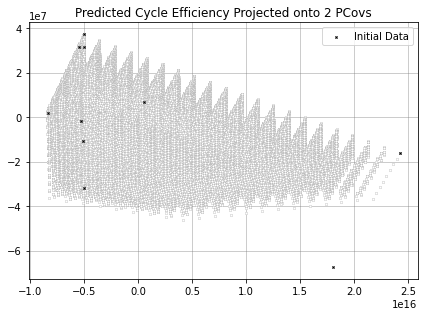

In [20]:
fig,ax=plt.subplots(1,figsize=(6,4.5), facecolor='white')
ax.grid(color='gray',axis='both',alpha=0.5)
ax.set_axisbelow(True)

cm = plt.cm.get_cmap('plasma_r')

sc = plt.scatter(T_pcovr_df['PC1'], T_pcovr_df['PC2'], s=8, c='white', edgecolors='k', linewidths=0.1, vmax = 102, vmin = 98, alpha=1)

sd1 = plt.scatter(X_pcovr_df['PC1'][:10], X_pcovr_df['PC2'][:10], s=8, c='black', edgecolors='k', linewidths=0.1, marker='X', label='Initial Data')
#sd2 = plt.scatter(X_pcovr_df['PC1'][24:50], X_pcovr_df['PC2'][24:50], s=16, c='None', edgecolors='k', linewidths=0.5, marker='^', label='1st Iter')
#sd3 = plt.scatter(X_pcovr_df['PC1'][50:], X_pcovr_df['PC2'][50:], s=8, c='None', edgecolors='k', linewidths=0.5, marker='s', label='2nd Iter')
#sd = plt.scatter(X_pcovr_df['PC1'][24:], X_pcovr_df['PC2'][24:], s=8, c='None', edgecolors='k', linewidths=0.5, marker='s')

#se = plt.scatter(Rec_pcovr_df['PC1'], Rec_pcovr_df['PC2'], s=4, c='white', edgecolors='k', linewidths=0.1)
#sf = plt.scatter(Rec_pcovr_df.iloc[:12]['PC1'], Rec_pcovr_df.iloc[:12]['PC2'], s=2, c='red', edgecolors='k', linewidths=0.1)

plt.title('Predicted Cycle Efficiency Projected onto 2 PCovs')

n = Gaus_data[:5].index + 1

#plt.xlim(-6,4)
#plt.ylim(-0.0000025,0.0000025)

plt.legend()
plt.tight_layout()

# plt.savefig('../Data/Exported Figures/Data Space Projected onto 2 PCovs.png', dpi=600)
plt.show()

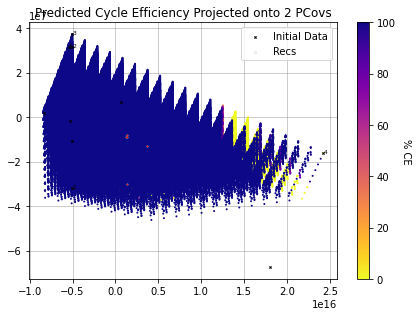

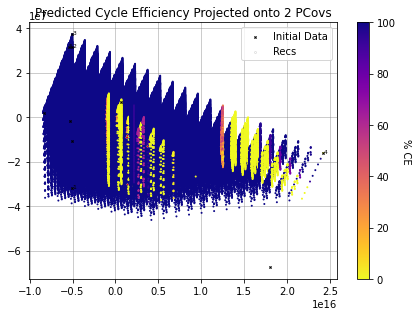

In [23]:
fig,ax=plt.subplots(1,figsize=(6,4.5), facecolor='white')
ax.grid(color='gray',axis='both',alpha=0.5)
ax.set_axisbelow(True)

cm = plt.cm.get_cmap('plasma_r')

sc = plt.scatter(T_pcovr_df['PC1'], T_pcovr_df['PC2'], s=4, c=Plotting_points_pred_sorted['Predicted CE'], cmap=cm, edgecolors='k', linewidths=0, vmin = 0, alpha=1)

sd1 = plt.scatter(X_pcovr_df['PC1'][:10], X_pcovr_df['PC2'][:10], s=8, c='black', edgecolors='k', linewidths=0.1, marker='X', label='Initial Data')
#sd2 = plt.scatter(X_pcovr_df['PC1'][24:48], X_pcovr_df['PC2'][24:48], s=16, c='None', edgecolors='k', linewidths=0.5, marker='^', label='1st Iter')
#sd3 = plt.scatter(X_pcovr_df['PC1'][48:], X_pcovr_df['PC2'][48:], s=8, c='None', edgecolors='k', linewidths=0.5, marker='s', label='2nd Iter')
#sd = plt.scatter(X_pcovr_df['PC1'][24:], X_pcovr_df['PC2'][24:], s=8, c='None', edgecolors='k', linewidths=0.5, marker='s')

se = plt.scatter(Rec_pcovr_df['PC1'], Rec_pcovr_df['PC2'], s=4, c='white', edgecolors='k', linewidths=0.1, label = 'Recs')
sf = plt.scatter(Rec_pcovr_df.iloc[:12]['PC1'], Rec_pcovr_df.iloc[:12]['PC2'], s=2, c='red', edgecolors='k', linewidths=0.1)

plt.title('Predicted Cycle Efficiency Projected onto 2 PCovs')

cbar = plt.colorbar(sc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('% CE', rotation=270)

n = Gaus_data[:5].index + 1

for i, txt in enumerate(n):
    plt.annotate(txt, (X_pcovr_df['PC1'][i]+0.005, X_pcovr_df['PC2'][i]+0.00000005), size=6, zorder=10)

plt.legend()

plt.tight_layout()
# plt.savefig('../Data/Exported Figures/Predicted Cycle Efficiency Projected onto 2 PCovs.png', dpi=600)
plt.show()

### Again but with points reversed:

fig2,ax2=plt.subplots(1,figsize=(6,4.5), facecolor='white')
ax2.grid(color='gray',axis='both',alpha=0.5)
ax2.set_axisbelow(True)

cm = plt.cm.get_cmap('plasma_r')

sc = plt.scatter(T_pcovr_df['PC1'].iloc[::-1], T_pcovr_df['PC2'].iloc[::-1], s=4, c=Plotting_points_pred_sorted['Predicted CE'].iloc[::-1], cmap=cm, edgecolors='k', linewidths=0, vmin = 0, alpha=1)

sd1 = plt.scatter(X_pcovr_df['PC1'][:10], X_pcovr_df['PC2'][:10], s=8, c='black', edgecolors='k', linewidths=0.1, marker='X', label='Initial Data')

se = plt.scatter(Rec_pcovr_df['PC1'], Rec_pcovr_df['PC2'], s=4, c='white', edgecolors='k', linewidths=0.1, label = 'Recs')
sf = plt.scatter(Rec_pcovr_df.iloc[:12]['PC1'], Rec_pcovr_df.iloc[:12]['PC2'], s=2, c='red', edgecolors='k', linewidths=0.1)

plt.title('Predicted Cycle Efficiency Projected onto 2 PCovs')

cbar2 = plt.colorbar(sc)
cbar2.ax.get_yaxis().labelpad = 15
cbar2.ax.set_ylabel('% CE', rotation=270)

n = Gaus_data[:5].index + 1

for i, txt in enumerate(n):
    plt.annotate(txt, (X_pcovr_df['PC1'][i]+0.005, X_pcovr_df['PC2'][i]+0.00000005), size=6, zorder=10)

plt.legend()

plt.tight_layout()
# plt.savefig('../Data/Exported Figures/Predicted Cycle Efficiency Projected onto 2 PCovs.png', dpi=600)
plt.show()


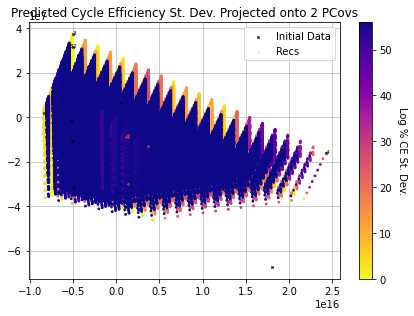

In [25]:
fig,ax=plt.subplots(1,figsize=(6,4.5), facecolor='white')
ax.grid(color='gray',axis='both',alpha=0.5)
ax.set_axisbelow(True)

cm = plt.cm.get_cmap('plasma_r')

sc = plt.scatter(T_pcovr_df['PC1'], T_pcovr_df['PC2'], s=8, c=Plotting_points_pred_sorted['Log Predicted CE StD'], cmap=cm, edgecolors='k', linewidths=0, vmin = 0, alpha=1)

sd1 = plt.scatter(X_pcovr_df['PC1'][:10], X_pcovr_df['PC2'][:10], s=8, c='black', edgecolors='k', linewidths=0.1, marker='X', label='Initial Data')
#sd2 = plt.scatter(X_pcovr_df['PC1'][24:48], X_pcovr_df['PC2'][24:48], s=16, c='None', edgecolors='k', linewidths=0.5, marker='^', label='1st Iter')
#sd3 = plt.scatter(X_pcovr_df['PC1'][48:], X_pcovr_df['PC2'][48:], s=8, c='None', edgecolors='k', linewidths=0.5, marker='s', label='2nd Iter')
#sd = plt.scatter(X_pcovr_df['PC1'][24:], X_pcovr_df['PC2'][24:], s=8, c='None', edgecolors='k', linewidths=0.5, marker='s')

se = plt.scatter(Rec_pcovr_df['PC1'], Rec_pcovr_df['PC2'], s=4, c='white', edgecolors='k', linewidths=0.1, label = 'Recs')
sf = plt.scatter(Rec_pcovr_df.iloc[:12]['PC1'], Rec_pcovr_df.iloc[:12]['PC2'], s=2, c='red', edgecolors='k', linewidths=0.1)

plt.title('Predicted Cycle Efficiency St. Dev. Projected onto 2 PCovs')

cbar = plt.colorbar(sc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Log % CE St. Dev.', rotation=270)

n = Gaus_data[:5].index + 1

for i, txt in enumerate(n):
    plt.annotate(txt, (X_pcovr_df['PC1'][i]+0.005, X_pcovr_df['PC2'][i]+0.00000005), size=6, zorder=10)

plt.legend()
plt.tight_layout()

# plt.savefig('../Data/Exported Figures/Predicted Cycle Efficiency Log St. Dev. Projected onto 2 PCovs.png', dpi=600)
plt.show()


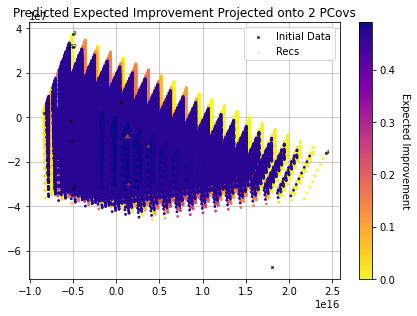

In [26]:
fig,ax=plt.subplots(1,figsize=(6,4.5), facecolor='white')
ax.grid(color='gray',axis='both',alpha=0.5)
ax.set_axisbelow(True)

cm = plt.cm.get_cmap('plasma_r')

sc = plt.scatter(T_pcovr_df['PC1'], T_pcovr_df['PC2'], s=8, c=Plotting_points_pred_sorted['Expected Improvement'], cmap=cm, edgecolors='k', linewidths=0, vmin = 0, alpha=1)

sd1 = plt.scatter(X_pcovr_df['PC1'][:10], X_pcovr_df['PC2'][:10], s=8, c='black', edgecolors='k', linewidths=0.1, marker='X', label='Initial Data')
#sd2 = plt.scatter(X_pcovr_df['PC1'][24:48], X_pcovr_df['PC2'][24:48], s=16, c='None', edgecolors='k', linewidths=0.5, marker='^', label='1st Iter')
#sd3 = plt.scatter(X_pcovr_df['PC1'][48:], X_pcovr_df['PC2'][48:], s=8, c='None', edgecolors='k', linewidths=0.5, marker='s', label='2nd Iter')
#sd = plt.scatter(X_pcovr_df['PC1'][24:], X_pcovr_df['PC2'][24:], s=8, c='None', edgecolors='k', linewidths=0.5, marker='s')

se = plt.scatter(Rec_pcovr_df['PC1'], Rec_pcovr_df['PC2'], s=4, c='white', edgecolors='k', linewidths=0.1, label = 'Recs')
sf = plt.scatter(Rec_pcovr_df.iloc[:12]['PC1'], Rec_pcovr_df.iloc[:12]['PC2'], s=2, c='red', edgecolors='k', linewidths=0.1)

plt.title('Predicted Expected Improvement Projected onto 2 PCovs')

cbar = plt.colorbar(sc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Expected Improvement', rotation=270)

n = Gaus_data[:5].index + 1

for i, txt in enumerate(n):
    plt.annotate(txt, (X_pcovr_df['PC1'][i]+0.005, X_pcovr_df['PC2'][i]+0.00000005), size=6, zorder=10)

plt.legend()
plt.tight_layout()

# plt.savefig('../Data/Exported Figures/Predicted Expected Improvement Projected onto 2 PCovs.png', dpi=600)
plt.show()